In [33]:
# Standard DS imports
import pandas as pd
import numpy as np

# Vizualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# NLP imports
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Custom imports
import acquire as a
import env

import os
import requests
import random

## Acquire

In [34]:
df = a.process_all_repos()

## Prepare

##### Prepare Steps:
- Lowercase All Text
- Remove accented characters and non-ASCII characters
- Remove special characters
- Tokenize
- Lemmatize
- Remove Stopwords
- Add extra Stopwords

In [35]:
df = a.transform_data(df, extra_stopwords=['githubcom', "'"])

In [36]:
df.head()

,repo,language,original,clean,lematized
0,/facebookresearch/ResponsibleNLP,Python,This repository hosts code and datasets relati...,repository hosts code datasets relating respon...,repository host code datasets relating respons...
1,/facebookresearch/projectaria_tools,C++,# Project Aria Tools Project Aria Tools is a ...,project aria tools project aria tools suite c ...,project aria tool project aria tool suite c py...
2,/facebookresearch/HolisticTraceAnalysis,Python,[![CircleCI](https://circleci.com/gh/facebookr...,circlecihttps circlecicom gh facebookresearch ...,circlecihttps circlecicom gh appcirclecicom pi...
3,/facebookresearch/fairseq2,Python,"<p align=""center""> <img src=""doc/static/img/...",p aligncenter img srcdoc static img logopng wi...,p aligncenter img srcdoc static img logopng wi...
4,/facebookresearch/seamless_communication,Python,![](seamlessM4T.png) # SeamlessM4T SeamlessM4T...,seamlessm4tpng seamlessm4t seamlessm4t designe...,seamlessm4tpng seamlessm4t seamlessm4t designe...


## Explore

In [37]:
py_words = ' '.join(df[df.language == 'Python'].lematized)
c_words = ' '.join(df[df.language == 'C++'].lematized)
jupiter_words = ' '.join(df[df.language == 'Jupyter Notebook'].lematized)
all_words = ' '.join(df.lematized)

In [38]:
# Get word counts for each language
py_counts =pd.Series(py_words.split()).value_counts()
c_counts =pd.Series(c_words.split()).value_counts()
jupiter_counts =pd.Series(jupiter_words.split()).value_counts()
all_counts =pd.Series(all_words.split()).value_counts()

In [39]:
# Get word frequencies for each language
py_freq = pd.Series(py_counts / py_counts.sum())
c_freq = pd.Series(c_counts / c_counts.sum())
jupiter_freq = pd.Series(jupiter_counts / jupiter_counts.sum())
all_freq = pd.Series(all_counts / all_counts.sum())

In [48]:
all_freq.head()

model      0.011737
data       0.006856
python     0.006720
install    0.005900
file       0.005360
Name: count, dtype: float64

In [40]:
# What are the most frequent py words?
py_counts.head(20)

model       930
python      528
data        478
install     421
&#9;        405
file        405
run         393
use         356
code        356
training    351
example     334
1           301
license     288
b           268
see         264
arxivorg    263
main        262
bash        259
ab          257
using       254
Name: count, dtype: int64

In [41]:
# What are the most frequent c words?
c_counts.head(20)

x          95
install    73
habitat    67
build      55
c          46
game       46
vrs        45
python     40
pytorch    35
data       34
use        34
conda      34
see        33
path       33
sim        32
1          32
file       28
model      28
license    28
http       27
Name: count, dtype: int64

In [42]:
# What are the most frequent jupiter words?
jupiter_counts.head(20)

model        142
td           105
dinov2        93
data          88
dataset       59
hrefhttps     59
tr            56
install       56
personal      54
run           52
file          49
1             49
python        49
license       45
http          44
please        43
path          42
use           39
see           38
2             38
Name: count, dtype: int64

<div class="alert alert-block alert-info"> 
<b>Takeaway:</b>
    
- Words like 
- Words like 
</div>

In [43]:
#Combine the value counts into one dataframe
word_counts = pd.concat([py_counts, c_counts, jupiter_counts, all_counts], axis=1)
word_counts.columns = ['py_counts', 'c_counts', 'jupiter_counts', 'all_counts']

# Fill the nulls with 0
word_counts.fillna(0, inplace=True)
#Recast all columns as integers
word_counts = word_counts.astype('int')

#take a look
word_counts.head()

,py_counts,c_counts,jupiter_counts,all_counts
model,930,28,142,1130
python,528,40,49,647
data,478,34,88,660
install,421,73,56,568
&#9;,405,9,5,419


In [50]:
#Combine the value counts into one dataframe
word_freq = pd.concat([py_freq, c_freq, jupiter_freq, all_freq], axis=1)
word_freq.columns = ['py_freq', 'c_freq', 'jupiter_freq', 'all_freq']

# Fill the nulls with 0
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,py_freq,c_freq,jupiter_freq,all_freq
model,0.012409,0.004291,0.015746,0.011737
python,0.007045,0.006129,0.005434,0.006720
data,0.006378,0.005210,0.009758,0.006856
install,0.005617,0.011186,0.006210,0.005900
&#9;,0.005404,0.001379,0.000554,0.004352


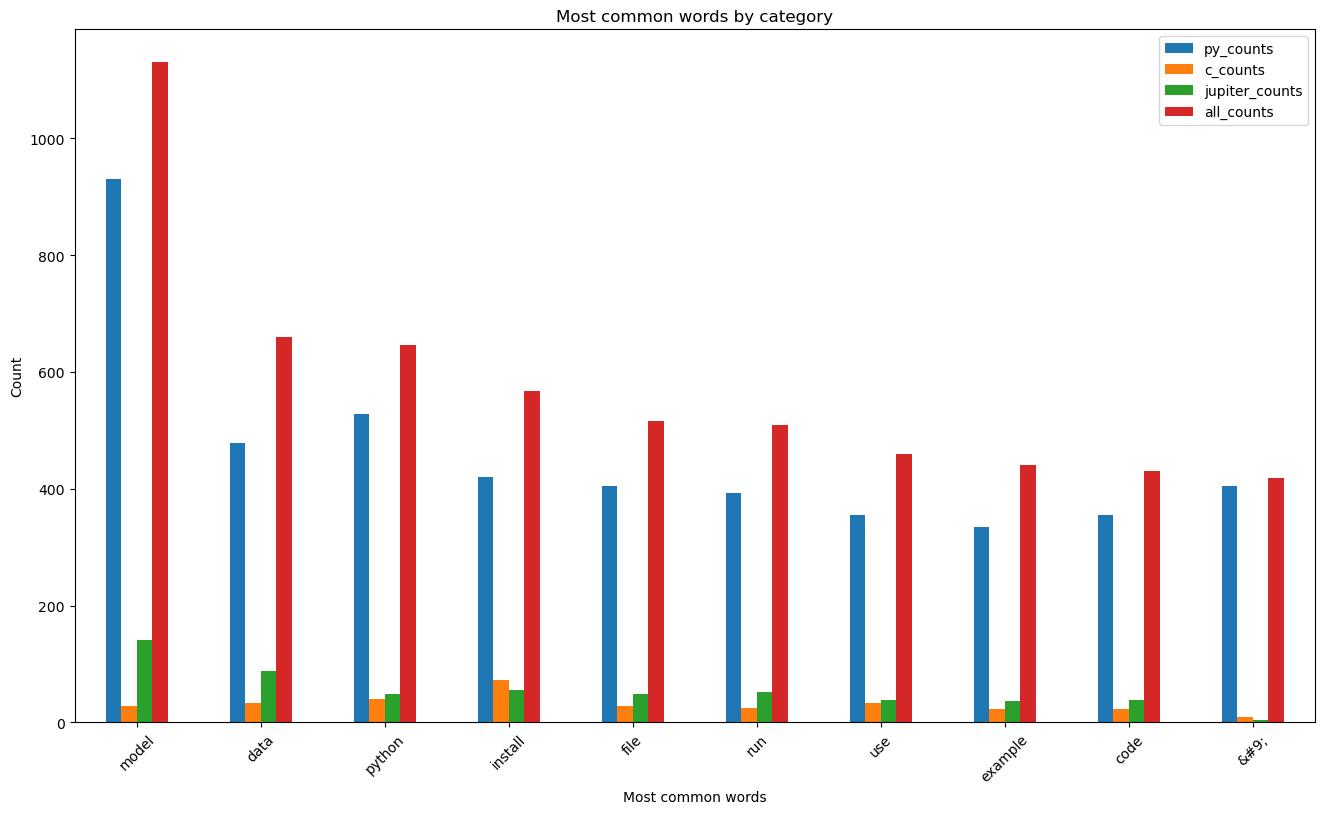

In [52]:
#Plot the most frequent words and color by label
word_counts.sort_values('all_counts', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

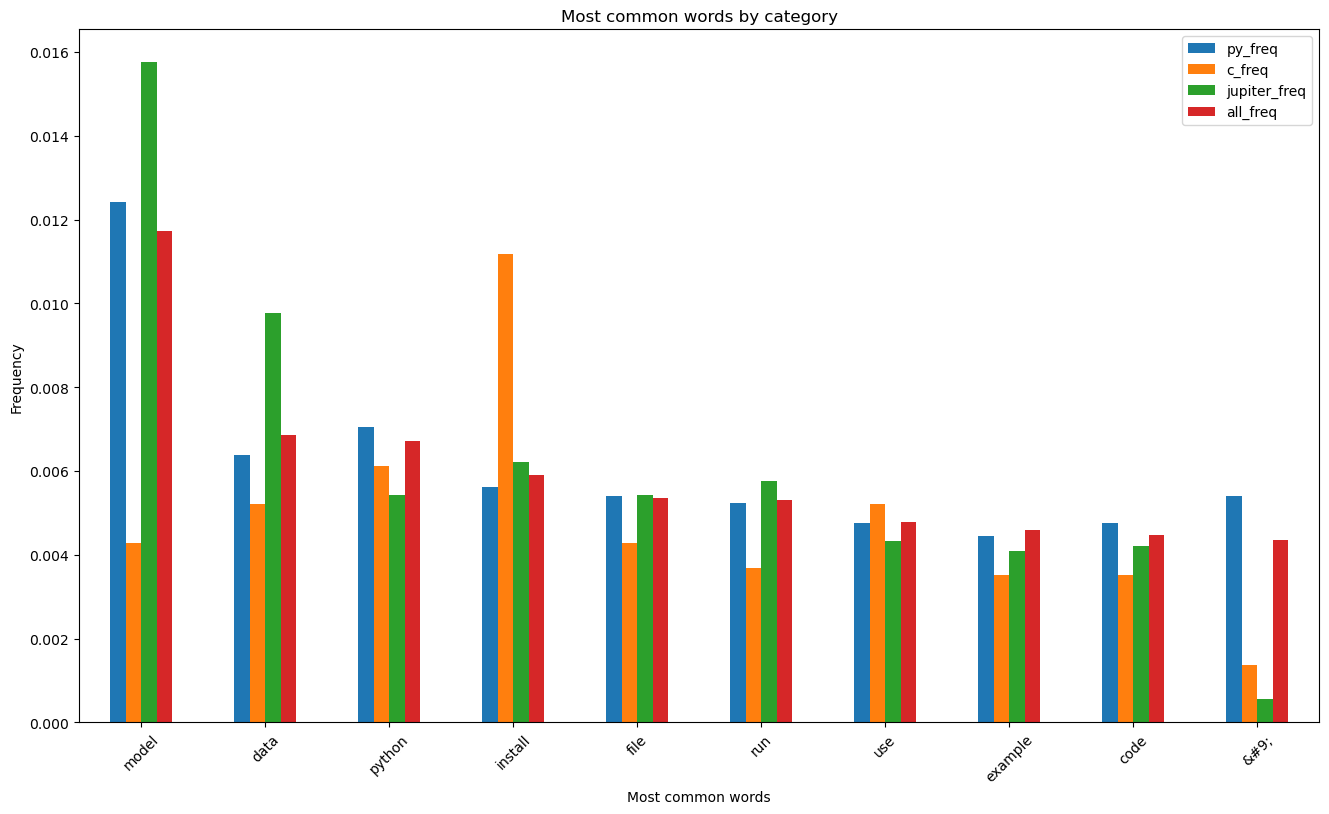

In [53]:
#Plot the most frequent words and color by label
word_freq.sort_values('all_freq', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()